Este notebook contiene el entrenamiento de los modelos de redes neuronales empleando los datos de KITTI, las arquitecturas definidas son las correspondientes a las últimas pruebas que se han realizado.

In [2]:
import pandas as pd
import numpy as np
import os
import warnings

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, UpSampling2D, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, LeakyReLU
from keras.initializers import he_normal
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.utils import plot_model
from keras import regularizers, layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
warnings.filterwarnings("ignore")

In [5]:
def read_velodyne_bin(file_path):
    """
    Funcion para leer los puntos de Velodyne de un archivo .bin

    Args:
    - file_path (str): Ruta del archivo .bin
    Returns:
    - points (np.array): Array de puntos con las coordenadas x, y, z
    """
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return points[:, :3]


In [6]:
original = 'ruta a las imagenes originales'
reduced = 'ruta a las imagenes con canales reducidos'

In [7]:
def load_paired_images(original_dir, downsampled_dir):
    """

    Carga los pares de imagenes originales y downsampled de un directorio especifico.
    Se asume que las imagenes estan nombradas en el mismo formato 'velodyne_XXXX.png' en ambos directorios.
    
    Args:
    - original_dir (str): Directorio que contiene las imagenes originales.
    - downsampled_dir (str): Directorio que contiene las imagenes downsampled.
    
    Returns:
    - lista de tuplas: Cada tupla contiene un par de imagenes (original, downsampled) como numpy arrays.
    """
    image_pairs = []
    
    # Coge todos los nombres de los archivos del directorio y los ordena. Las instancias de su versión auxiliar tienen el mismo nombre, por lo que solo es necesario
    # referenciar a uno de los directorios.
    downsampled_images = sorted([f for f in os.listdir(downsampled_dir) if f.endswith('.png')])
    

    for downsampled_image_filename in downsampled_images:   # Itera sobre cada archivo en el directorio de imagenes
        downsampled_image_path = os.path.join(downsampled_dir, downsampled_image_filename)   # Genera la ruta del archivo para la imagen
        
        # Genera la ruta del archivo para las imagenes de la carpeta auxiliar
        original_image_filename = downsampled_image_filename
        original_image_path = os.path.join(original_dir, original_image_filename)
        
        # Carga las imagenes originales y downsampled
        downsampled_image = Image.open(downsampled_image_path).convert('L')
        original_image = Image.open(original_image_path).convert('L')
        
        # Añade las imagenes a la lista de pares
        image_pairs.append((np.array(original_image, dtype=np.float32) / 255.0, 
                            np.array(downsampled_image, dtype=np.float32) / 255.0))
    
    return image_pairs

In [8]:
def load_lidar_images(original_dir, downsampled_dir):
    """
    Carga las imagenes de la nube de puntos LiDAR de los directorios especificados para las imagenes originales y reducidos.
    La funcion asume que las imagenes estan nombradas en el mismo formato 'velodyne_XXXX.png' en ambos directorios.
    
    Args:
    - original_dir (str): Directorio que contiene las imagenes originales.
    - downsampled_dir (str): Directorio que contiene las imagenes reducidas.
    
    Returns:
    - original images: Las imagenes originales de la nube de puntos
    - downsampled images: Las imagenes reducidas de la nube de puntos
    """
    original_list = []
    downsampled_list = []
    
    # Coge todos los nombres de los archivos del directorio y los ordena
    downsampled_images = sorted([f for f in os.listdir(downsampled_dir) if f.endswith('.png')])
    
    for downsampled_image_filename in downsampled_images:
        downsampled_image_path = os.path.join(downsampled_dir, downsampled_image_filename)
        
        original_image_filename = downsampled_image_filename
        original_image_path = os.path.join(original_dir, original_image_filename)
        
        # Carga de imágenes en blanco y negro
        # downsampled_image = Image.open(downsampled_image_path).convert('L')
        # original_image = Image.open(original_image_path).convert('L')

        # Carga de imágenes en color
        downsampled_image = Image.open(downsampled_image_path).convert('RGB')
        original_image = Image.open(original_image_path).convert('RGB')
        
    
        original_list.append(np.array(original_image, dtype=np.float32) / 255.0)
        downsampled_list.append(np.array(downsampled_image, dtype=np.float32) / 255.0)

    # Convierte las listas en arrays de numpy
    original_array = np.stack(original_list, axis=0)
    downsampled_array = np.stack(downsampled_list, axis=0)
    
    return original_array, downsampled_array

In [9]:
original_processed, downsample_processed = load_lidar_images(original, reduced)

In [11]:
# En caso de querer trabajar con imágenes de un tamaño diferente, se pueden recortar.

# original_processed = np.delete(original_processed, 0, axis=2)
# downsample_processed = np.delete(downsample_processed, 0, axis=2)

In [13]:
def visualize_image(original_image, downsampled_image):
    """
    Visualiza un par de imagenes de una lista de pares de imagenes.
    
    Args:
    - Tupla de imágenes (list of tuples): Cada tupla contiene un par de imágenes (original, downsampled) como numpy arrays.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')  # Hide axes ticks

    ax2.imshow(downsampled_image)
    ax2.set_title('Downsampled Image')
    ax2.axis('off')
    
    plt.show()

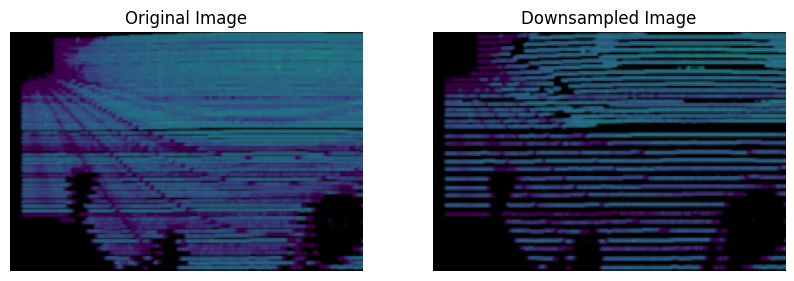

In [14]:
visualize_image(original_processed[0], downsample_processed[0])

## Interpolación de los puntos mediante Interpolación

Para establecer una base de la que partir realizamos interpolación sobre imagen, un proceso donde empleando datos conocidos se estiman los valores en coordenadas desconocidas. El objetivo es obtener la mejor aproximación en la intensidad de los pixeles en base a sus vecinos en la imagen.

La segunda aproximación, interpolación aplicada sobre la nube de puntos tridimensional, será realizada en el notebook "interpolation.ipynb"

#### Interpolación mediante Nearest Replication

Uno de los modelos de interpolación más simple, se basa en la replicación de los pixeles vecinos, replicando la intensidad del color sobre los nuevos pixeles. El problema que conlleva el uso de este tipo de algoritmos es la aparición de bloques de pixeles en la imagen, ya que debido a su naturaleza, se generan regiones de pixeles con la misma intensidad.

In [ ]:
image = downsample_processed[0]

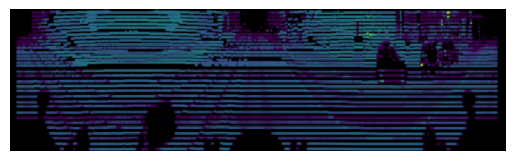

In [125]:
import cv2
new_image = cv2.resize(image, (700, 200), interpolation=cv2.INTER_NEAREST)    # Para poder apreciar mejor los cambios se recomienda aumentear el tamaño de la imagen

plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.show()

#### Linear Interpolation

La interpolación bilinear deriva de la interpolación lineal simple, toma la intensidad media de los 4 vecinos más cercanos para promediar los nuevos pixeles a la hora de escalar la imagen, obteniendo una representación más precisa del entorno teniendo en consideración una ventana de 2x2 del pixel objetivo.

El problema derivado en el uso de este tipo de algoritmos es la aparición de defuminado cuando la imagen es reescalada a un tamaño considerable. La mejora de resolución no ayuda a la obtención de nuevas capas sino a la mejora de las capas existentes

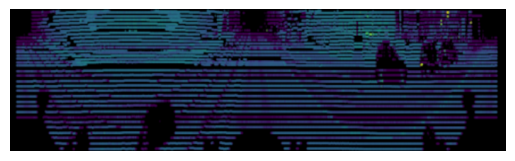

In [126]:
scaled_image_linear = cv2.resize(image, (700, 200), interpolation=cv2.INTER_LINEAR)   # Para poder apreciar mejor los cambios se recomienda aumentear el tamaño de la imagen

# Visualizamos la nueva imagen
plt.imshow(scaled_image_linear, cmap='gray')
plt.axis('off')
plt.show()

### Cubic Interpolation

Es una extensión de la interpolación cúbica que se aplica sobre ventanas de píxeles vecinos, específicamente trabaja con una ventana de 4 $\times$ 4 píxeles.

Similar a la interpolación bilineal, la interpolación bicúbica no propicia la generación de bloques de píxeles que empleando el método del vecino más cercano, pero sí genera un difuminado de la imagen al tratar de cambiar su tamaño.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


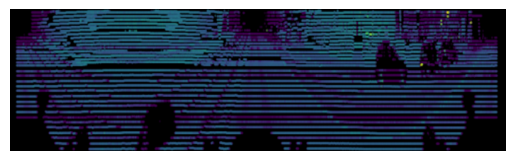

In [127]:
import cv2
new_image = cv2.resize(image, (700, 200), interpolation=cv2.INTER_CUBIC)    # Para poder apreciar mejor los cambios se recomienda aumentear el tamaño de la imagen

# Visualizamos la nueva imagen
plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.show()

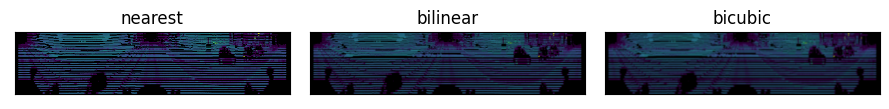

In [128]:
methods = ['nearest', 'bilinear', 'bicubic']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, interp_method in zip(axs.flat, methods):
    ax.imshow(image, interpolation=interp_method, cmap='viridis')
    ax.set_title(str(interp_method))

plt.tight_layout()
plt.show()

## Autoencoder

Las arquitecturas definidas a continuación son las iteraciones de las últimas pruebas realizadas. No se corresponden con los mejores resultados ni las estructuras presentadas en la memoria.

***

#### Imagenes completas

In [15]:
# Mantenemos las imágenes restantes como conjunto de test
orig_test = original_processed[1000:]
down_test = downsample_processed[1000:]

# Separamos las primeras 3500 imágenes para entrenamiento
original_processed = original_processed[:1000]
downsample_processed = downsample_processed[:1000]

#### Imagenes recortadas

In [16]:
# # Mantenemos las imágenes restantes como conjunto de test
# orig_test = original_processed[3500:]
# down_test = downsample_processed[3500:]

# # Separamos las primeras 3500 imágenes para entrenamiento
# original_processed = original_processed[:3500]
# downsample_processed = downsample_processed[:3500]

***

In [17]:
train_orig, test_orig, train_down, test_down = train_test_split(original_processed, downsample_processed, test_size=0.2, random_state=42)

In [ ]:
plt.hist(test_orig.flatten(), bins=100, color='blue', alpha=0.5, label='Original', density=True)

In [21]:
print(train_orig.shape)
print(test_orig.shape)
print(train_down.shape)
print(test_down.shape)

(2800, 144, 212, 3)
(700, 144, 212, 3)
(2800, 144, 212, 3)
(700, 144, 212, 3)


In [22]:
# Reshape the data to include a channel dimension
train_orig = np.expand_dims(train_orig, axis=-1)
train_down = np.expand_dims(train_down, axis=-1)
test_orig = np.expand_dims(test_orig, axis=-1)
test_down = np.expand_dims(test_down, axis=-1)
orig_test = np.expand_dims(orig_test, axis=-1)
down_test = np.expand_dims(down_test, axis=-1)  

print("New Train Original Shape:", train_orig.shape)
print("New Train Downsampled Shape:", train_down.shape)
print("New Test Original Shape:", test_orig.shape)
print("New Test Downsampled Shape:", test_down.shape)
print("New Original Test Shape:", orig_test.shape)
print("New Downsampled Test Shape:", down_test.shape)

New Train Original Shape: (2800, 144, 212, 3, 1)
New Train Downsampled Shape: (2800, 144, 212, 3, 1)
New Test Original Shape: (700, 144, 212, 3, 1)
New Test Downsampled Shape: (700, 144, 212, 3, 1)
New Original Test Shape: (319, 144, 212, 3, 1)
New Downsampled Test Shape: (319, 144, 212, 3, 1)


Counts: [ 5477870  2697806  2724136  2936850  3245526  4416591  7819698 13757817
 15070538 13406002 11916082 12899045 10126356  4748693  5717954  7015220
  5908248  6841592  6778048  6115316  6006921  5890667  5833260  6291796
  7596311 12859770 10572652  1173845    63457    54405    46932    39970
    34205    24482    27755    25156    23259    20464    19246    18069
    17749    16768    16122    17334     9774     5977     6287     9937
     3754     1457]
Bin edges: [0.00392157 0.02329412 0.04266667 0.06203922 0.08141176 0.10078432
 0.12015686 0.1395294  0.15890196 0.17827451 0.19764706 0.2170196
 0.23639216 0.2557647  0.27513725 0.2945098  0.31388235 0.3332549
 0.35262746 0.372      0.39137256 0.41074508 0.43011764 0.4494902
 0.46886274 0.4882353  0.5076078  0.5269804  0.5463529  0.5657255
 0.585098   0.6044706  0.62384313 0.6432157  0.66258824 0.68196076
 0.70133334 0.72070587 0.74007845 0.759451   0.77882355 0.7981961
 0.8175686  0.8369412  0.8563137  0.8756863  0.8950588  0.9

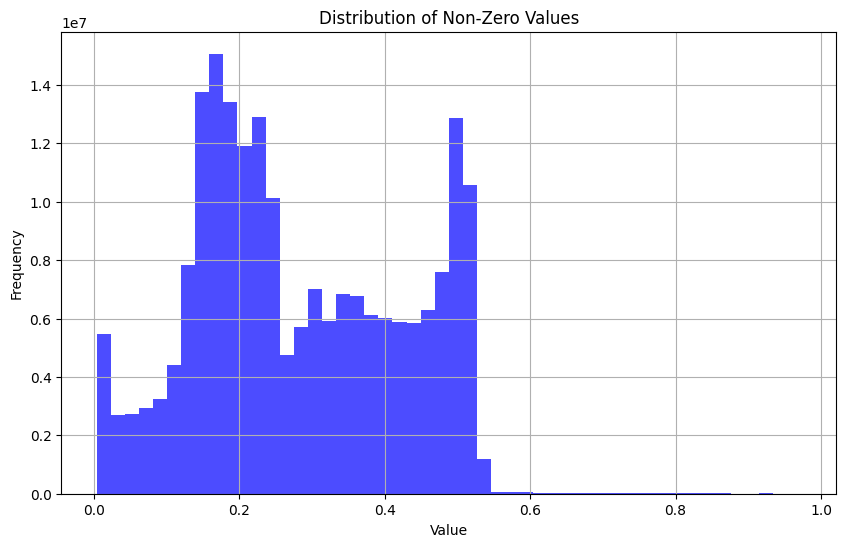

In [24]:
non_zero_data = train_orig[train_orig != 0].flatten()

# Calculate the histogram
counts, bin_edges = np.histogram(non_zero_data, bins=50)  # Adjust bins as needed

# Print the histogram data
print("Counts:", counts)
print("Bin edges:", bin_edges)

# Visualization using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(non_zero_data, bins=50, color='blue', alpha=0.7)  # Histogram plotting
plt.title("Distribution of Non-Zero Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [25]:
non_zero_mask = train_orig != 0

# Calculate the mean of elements that are not zero
mean_value = np.median(train_orig[non_zero_mask])

print("Mean value excluding zeros:", mean_value)

Mean value excluding zeros: 0.24705882


In [26]:
# # import standard scaler
# from sklearn.preprocessing import StandardScaler

# # create a scaler object
# scaler = StandardScaler()

# # fit and transform the data
# train_orig_scaled = scaler.fit_transform(train_orig.reshape(-1, 1)).reshape(train_orig.shape)
# train_down_scaled = scaler.transform(train_down.reshape(-1, 1)).reshape(train_down.shape)
# test_orig_scaled = scaler.transform(test_orig.reshape(-1, 1)).reshape(test_orig.shape)
# test_down_scaled = scaler.transform(test_down.reshape(-1, 1)).reshape(test_down.shape)

In [29]:
def plot_loss(h, EPOCHS):
    LOSS = 0
    training = np.zeros(EPOCHS)
    testing = np.zeros(EPOCHS)
    training = h.history['loss']
    testing = h.history['val_loss']

    epochs = range(1, EPOCHS + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training, 'b-', label='Training loss')
    plt.plot(epochs, testing, 'y-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [30]:
input_dim = (144, 212, 3)
input_layer = Input(shape=input_dim)
EPOCHS = 10

#### Modelo Simple 1 (outdated)

In [31]:
# # Encoder
encoder = Conv2D(32, (11, 11), activation='relu', padding='same')(input_layer)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)

encoder = Conv2D(64, (11, 11), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.3)(encoder)
# encoder = BatchNormalization()(encoder)
# encoder = Dropout(0.3)(encoder)

# # encoder = Conv2D(128, (7, 7), activation='relu', padding='same')(encoder)
# # encoder = BatchNormalization()(encoder)
# # encoder = Dropout(0.3)(encoder)

# # encoder = Conv2D(256, (7, 7), activation='relu', padding='same')(encoder)
# # encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)

# # encoder = Dense(128, activation='relu')(encoder)

# # Decoder
# decoder = Conv2DTranspose(32, (12, 12), activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(64, (11, 11), strides=2, activation='relu', padding='same')(encoder)
decoder = Dropout(0.3)(decoder)
decoder = Conv2DTranspose(32, (11, 11), strides=2, activation='relu', padding='same')(decoder)
# # decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (7, 7), activation='sigmoid', padding='same')(decoder)

#### Modelo auxiliar (última iteración aplicada a las imágenes segmentadas)

In [36]:
encoder = Conv2D(32, (11, 11), activation='relu', padding='same')(input_layer)
encoder = Conv2D(64, (11, 11), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)

encoder = Conv2D(128, (7, 7), activation='relu', padding='same')(encoder)
encoder = Conv2D(128, (7, 7), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.3)(encoder)

# encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
# encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D((2, 2), padding='same')(encoder)
# encoder = Dropout(0.3)(encoder)

# decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
# decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)
# decoder = Dropout(0.3)(decoder)

decoder = Conv2DTranspose(128, (7, 7), strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2D(128, (7, 7), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2DTranspose(64, (11, 11), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2D(32, (11, 11), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(3, (7, 7), activation='sigmoid', padding='same')(decoder)

In [37]:
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [38]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 212, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 144, 212, 32)      11648     
                                                                 
 conv2d_10 (Conv2D)          (None, 144, 212, 64)      247872    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 72, 106, 64)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 106, 128)      401536    
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 106, 128)      802944    
                                                           

In [ ]:
history = autoencoder.fit(train_down, train_orig, epochs=EPOCHS, batch_size=16, validation_data=(test_down, test_orig))

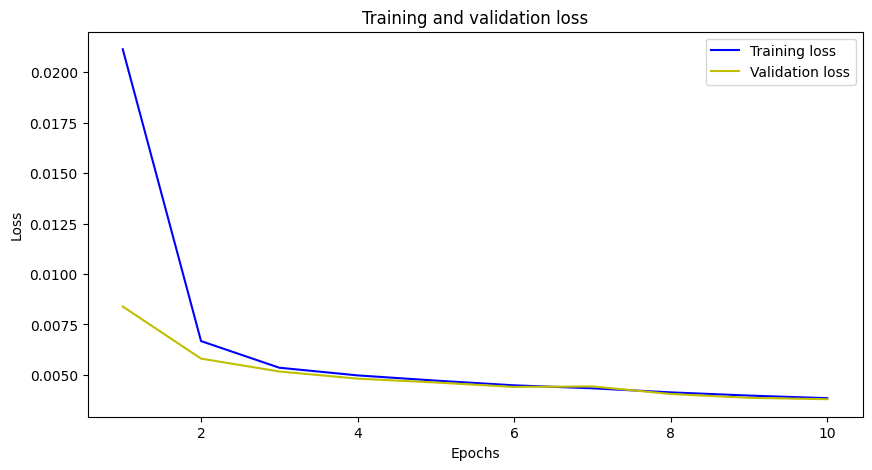

In [ ]:
plot_loss(history, EPOCHS)

In [ ]:
predictions = autoencoder.predict(down_test)

9/9 [==============================] - 92s 10s/step


In [ ]:
predictions[0].shape

(144, 640, 3)

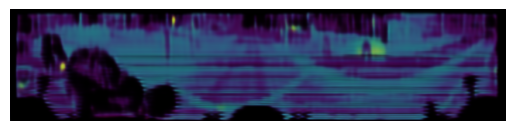

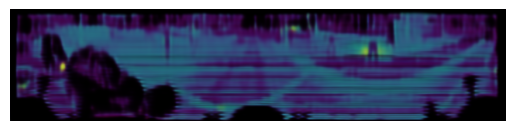

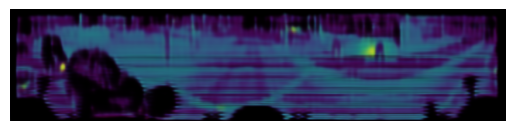

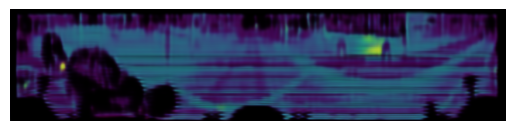

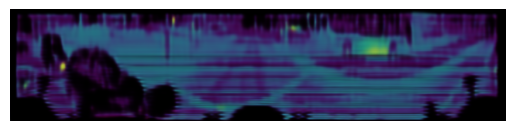

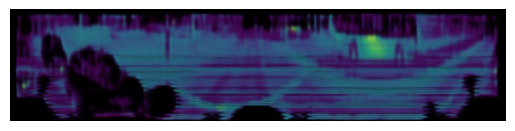

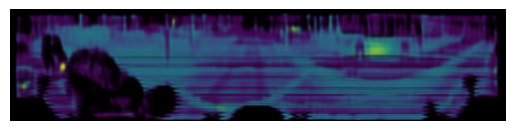

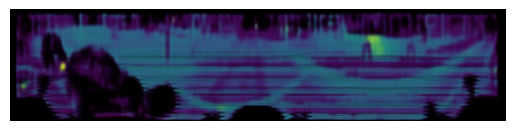

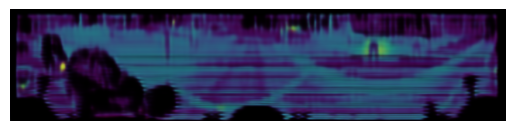

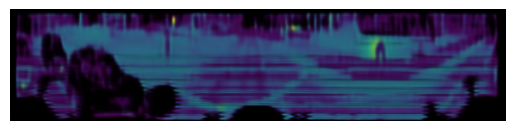

In [ ]:
# see first 10 predictions, only prediction images
for i in range(10):
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

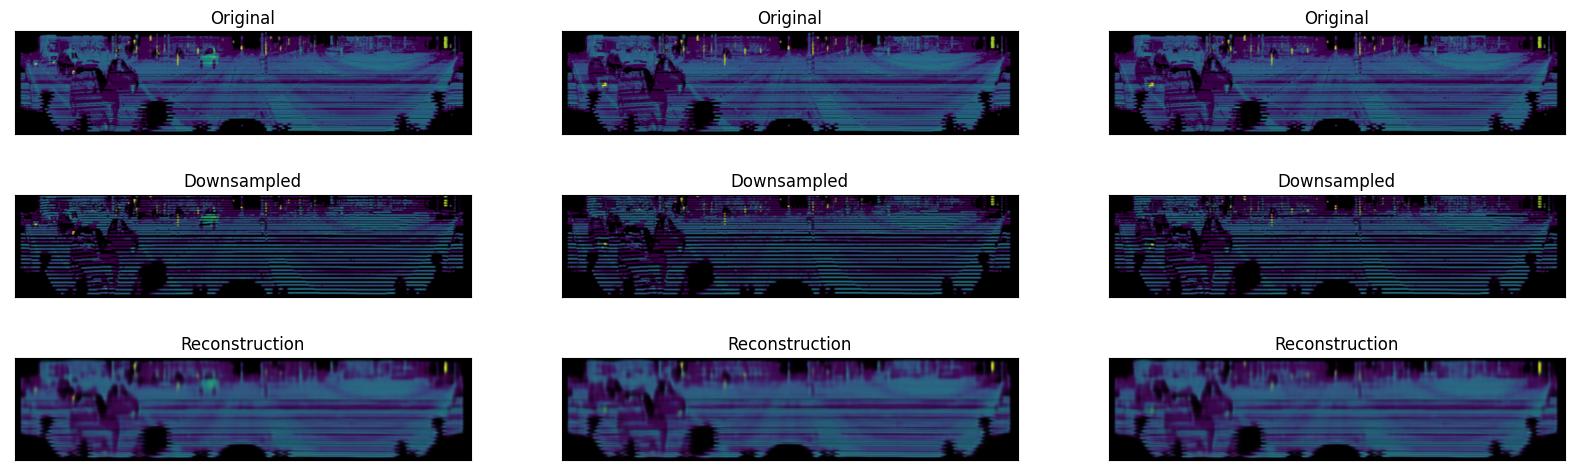

In [ ]:
# Number of images to display
n = 3  

# Select 3 random indices from the down_test dataset
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Display original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 212, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display downsampled image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 212, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 212, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Counts: [11645978  2018187  1525471  1330344  1229249  1246767  1983797  3256850
  4394783  4722547  4967761  3893629  2716390  1561472  1529515  1768180
  2015954  2152834  2237804  2165903  2174527  2201745  2215645  2433266
  2739811  2926945  2252151   118950    23743     4582     2704     1910
     1771     1561     1491     1581     1568     1520     1144     1160
     1175     1126     1055     1025     1044      806      649      566
      302      102]
Bin edges: [7.2369964e-11 1.9136913e-02 3.8273826e-02 5.7410739e-02 7.6547652e-02
 9.5684566e-02 1.1482148e-01 1.3395838e-01 1.5309530e-01 1.7223221e-01
 1.9136913e-01 2.1050604e-01 2.2964296e-01 2.4877986e-01 2.6791677e-01
 2.8705370e-01 3.0619061e-01 3.2532752e-01 3.4446442e-01 3.6360136e-01
 3.8273826e-01 4.0187517e-01 4.2101207e-01 4.4014901e-01 4.5928591e-01
 4.7842282e-01 4.9755973e-01 5.1669663e-01 5.3583354e-01 5.5497044e-01
 5.7410741e-01 5.9324431e-01 6.1238122e-01 6.3151813e-01 6.5065503e-01
 6.6979194e-01 6.8892884e-

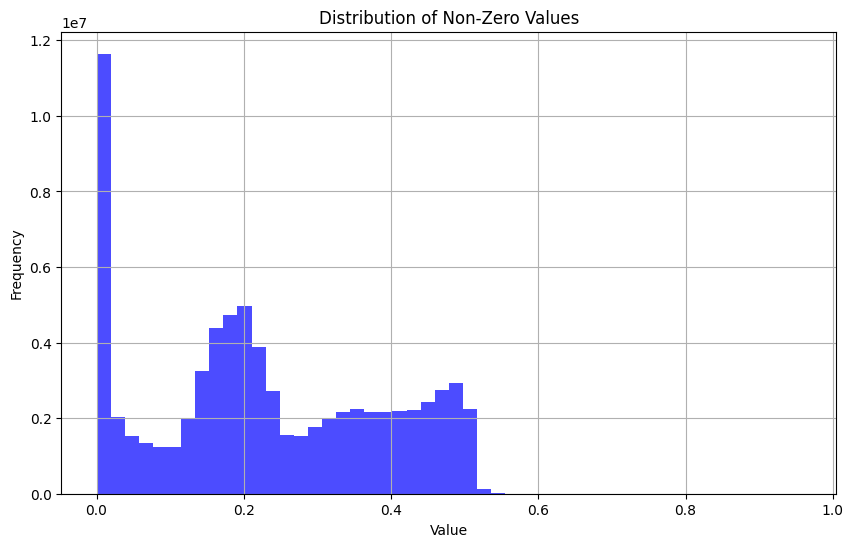

In [161]:
# Comprobamos la distribución de los valores no nulos
non_zero_data = predictions[predictions != 0].flatten()
data = predictions.flatten()


counts, bin_edges = np.histogram(data, bins=50)

print("Counts:", counts)
print("Bin edges:", bin_edges)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Non-Zero Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Modelo 2

En esta última iteración se ha hecho una prueba empleando AveragePooling2D en vez de MaxPooling2D, como se comentó en la memoria, las reconstrucciones tienen un mayor grado de difuminado. Incluso usando una red más potente se pierde definición en los contornos.

Se recomienda emplear MaxPooling

In [38]:
# Encoder
encoder = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
encoder = Conv2D(32, (5, 5), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Conv2D(64, (5, 5), activation='relu', padding='same')(encoder)
encoder = Conv2D(64, (5, 5), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Conv2D(128, (5, 5), activation='relu', padding='same')(encoder)
encoder = Conv2D(128, (5, 5), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.3)(encoder)

encoder = Conv2D(256, (5, 5), activation='relu', padding='same')(encoder)
encoder = Conv2D(256, (5, 5), activation='relu', padding='same')(encoder)
# encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder = Dropout(0.2)(encoder)
# encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)

# Decoder
# decoder = Conv2DTranspose(32, (12, 12), activation='relu', padding='same')(encoder)
# decoder = Conv2DTranspose(512, (3, 3), activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(256, (5, 5), strides=2, activation='relu', padding='same')(encoder)
decoder = Conv2DTranspose(256, (5, 5), activation='relu', padding='same')(decoder)
encoder = Dropout(0.2)(encoder)

decoder = Conv2DTranspose(128, (5, 5), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(128, (5, 5), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
encoder = Dropout(0.2)(encoder)
# decoder = Dropout(0.3)(decoder)
decoder = Conv2DTranspose(64, (5, 5), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(32, (5, 5), activation='relu', padding='same')(decoder)
# decoder = UpSampling2D((2, 2))(decoder)

decoder = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(decoder)

In [39]:
autoencoder1 = Model(inputs=input_layer, outputs=decoder)

In [40]:
autoencoder1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 640, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 640, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 640, 32)      25632     
                                                                 
 average_pooling2d (AverageP  (None, 72, 320, 32)      0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 72, 320, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 320, 64)       51264     
                                                             

In [165]:
history = autoencoder1.fit(train_down, train_orig, epochs=EPOCHS, batch_size=16, validation_data=(test_down, test_orig))

Epoch 1/10
50/50 [==============================] - 500s 10s/step - loss: 0.0406 - val_loss: 0.0149
Epoch 2/10
50/50 [==============================] - 499s 10s/step - loss: 0.0117 - val_loss: 0.0086
Epoch 3/10
50/50 [==============================] - 498s 10s/step - loss: 0.0076 - val_loss: 0.0072
Epoch 4/10
50/50 [==============================] - 499s 10s/step - loss: 0.0065 - val_loss: 0.0061
Epoch 5/10
50/50 [==============================] - 500s 10s/step - loss: 0.0058 - val_loss: 0.0057
Epoch 6/10
50/50 [==============================] - 500s 10s/step - loss: 0.0056 - val_loss: 0.0058
Epoch 7/10
50/50 [==============================] - 498s 10s/step - loss: 0.0053 - val_loss: 0.0051
Epoch 8/10
50/50 [==============================] - 498s 10s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/10
50/50 [==============================] - 499s 10s/step - loss: 0.0049 - val_loss: 0.0048
Epoch 10/10
50/50 [==============================] - 499s 10s/step - loss: 0.0047 - val_loss: 0.0046

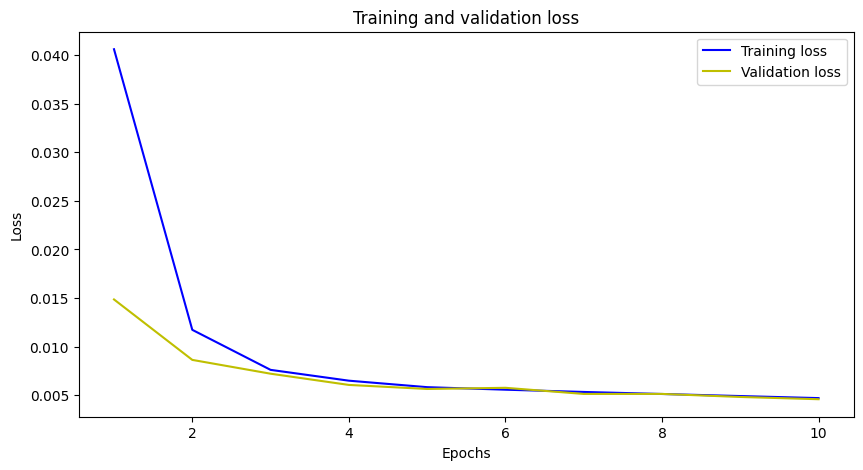

In [166]:
plot_loss(history, EPOCHS)

In [167]:
predictions = autoencoder1.predict(down_test)

9/9 [==============================] - 49s 5s/step


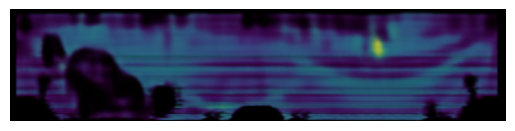

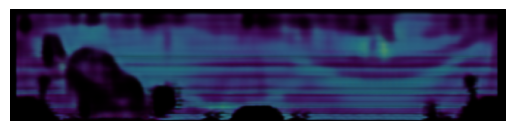

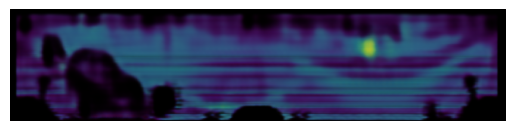

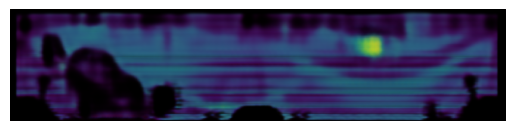

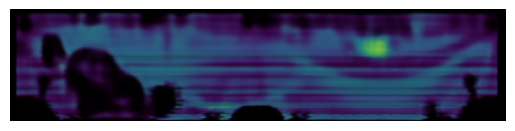

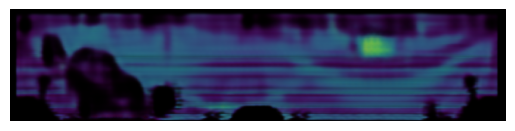

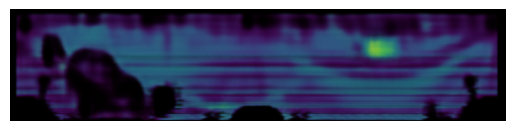

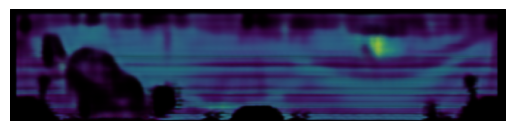

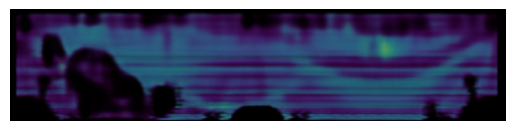

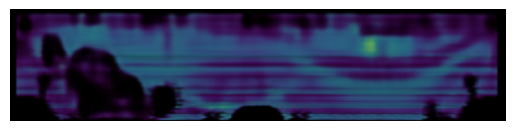

In [168]:
# see first 10 predictions, only prediction images
for i in range(10):
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

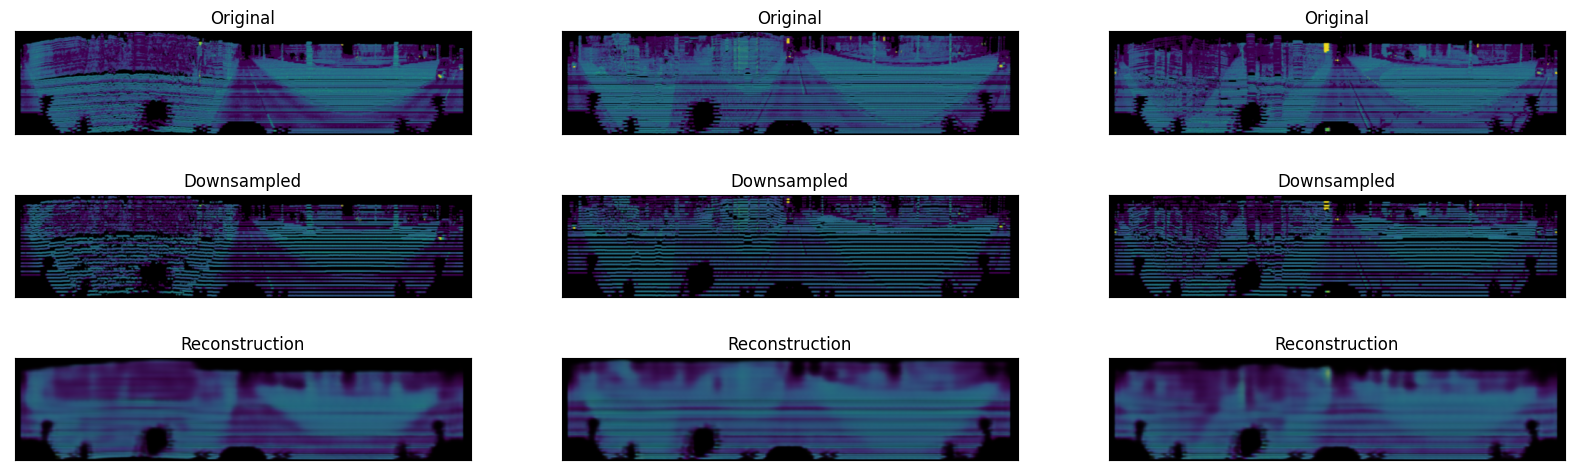

In [169]:
# Muestreo de 3 imágenes aleatorios, comparación de la imagen original, downsampled y reconstrucción

n = 3  
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

***

## U-Net

Al igual que el modelo 2, en esta última prueba se ha decidido emplear AveragePooling en lugar de MaxPooling. Las conclusiones a los que se han llegado son los mismos

In [170]:
def unet_model(input_size=input_dim):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(16, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    # p1 = MaxPooling2D((2, 2))(c1)
    p1 = AveragePooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    # p2 = MaxPooling2D((2, 2))(c2)
    p2 = AveragePooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    # p3 = MaxPooling2D((2, 2))(c3)
    p3 = AveragePooling2D((2, 2))(c3)
    
    # Cuello de botella
    c4 = Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    d = Dropout(0.5)(c4)

    # Decoder
    u6 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(d)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    
    u7 = Conv2DTranspose(32, (7, 7), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    
    u8 = Conv2DTranspose(16, (7, 7), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(16, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    
    # Capa de salida
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


u_net = unet_model()

In [171]:
u_net.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 144, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_62 (Conv2D)             (None, 144, 640, 16  2368        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d_5 (AveragePo  (None, 72, 320, 16)  0          ['conv2d_62[0][0]']              
 oling2D)                                                                                   

Epoch 1/10
50/50 [==============================] - 256s 5s/step - loss: 0.0388 - val_loss: 0.0200
Epoch 2/10
50/50 [==============================] - 254s 5s/step - loss: 0.0151 - val_loss: 0.0112
Epoch 3/10
50/50 [==============================] - 255s 5s/step - loss: 0.0090 - val_loss: 0.0070
Epoch 4/10
50/50 [==============================] - 255s 5s/step - loss: 0.0057 - val_loss: 0.0052
Epoch 5/10
50/50 [==============================] - 255s 5s/step - loss: 0.0048 - val_loss: 0.0047
Epoch 6/10
50/50 [==============================] - 256s 5s/step - loss: 0.0044 - val_loss: 0.0044
Epoch 7/10
50/50 [==============================] - 255s 5s/step - loss: 0.0042 - val_loss: 0.0042
Epoch 8/10
50/50 [==============================] - 254s 5s/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/10
50/50 [==============================] - 254s 5s/step - loss: 0.0039 - val_loss: 0.0039
Epoch 10/10
50/50 [==============================] - 255s 5s/step - loss: 0.0037 - val_loss: 0.0039


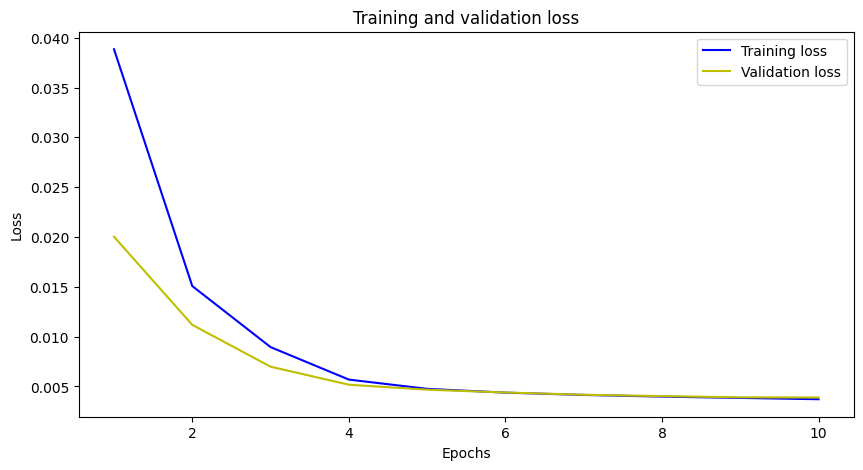

In [172]:
history = u_net.fit(train_down, train_orig, epochs=EPOCHS, batch_size=16, validation_data=(test_down, test_orig))

plot_loss(history, EPOCHS)

In [173]:
predictions = u_net.predict(down_test)

9/9 [==============================] - 17s 2s/step


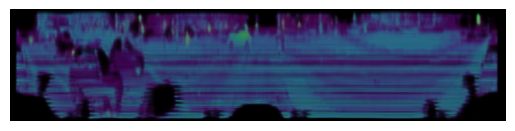

In [174]:
plt.imshow(predictions[210])
plt.axis('off')
plt.show()

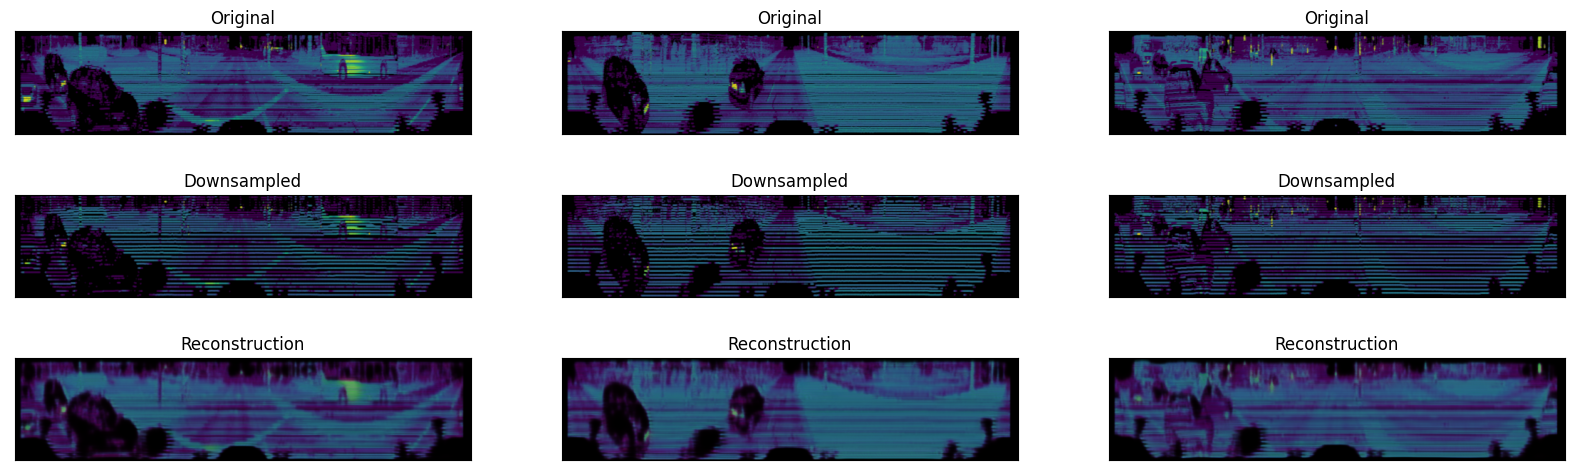

In [175]:
n = 3  
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### UNet 2

In [176]:
def unet_model(input_size=input_dim):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    # p1 = MaxPooling2D((2, 2))(c1)
    p1 = AveragePooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    # p2 = MaxPooling2D((2, 2))(c2)
    p2 = AveragePooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    # p3 = MaxPooling2D((2, 2))(c3)
    p3 = AveragePooling2D((2, 2))(c3)
    
    # Cuello de botella
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    d = Dropout(0.3)(c4)

    # Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    # Capa de salida
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

u_net = unet_model()

In [177]:
u_net.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 144, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_70 (Conv2D)             (None, 144, 640, 32  896         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 144, 640, 32  9248        ['conv2d_70[0][0]']              
                                )                                                           

In [178]:
history = u_net.fit(train_down, train_orig, epochs=20, batch_size=32, validation_data=(test_down, test_orig))

Epoch 1/20
25/25 [==============================] - 318s 12s/step - loss: 0.0399 - val_loss: 0.0100
Epoch 2/20
25/25 [==============================] - 308s 12s/step - loss: 0.0075 - val_loss: 0.0065
Epoch 3/20
25/25 [==============================] - 309s 12s/step - loss: 0.0059 - val_loss: 0.0057
Epoch 4/20
25/25 [==============================] - 308s 12s/step - loss: 0.0053 - val_loss: 0.0053
Epoch 5/20
25/25 [==============================] - 308s 12s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 6/20
25/25 [==============================] - 307s 12s/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/20
25/25 [==============================] - 309s 12s/step - loss: 0.0045 - val_loss: 0.0045
Epoch 8/20
25/25 [==============================] - 309s 12s/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/20
25/25 [==============================] - 309s 12s/step - loss: 0.0041 - val_loss: 0.0042
Epoch 10/20
25/25 [==============================] - 310s 12s/step - loss: 0.0040 - val_loss: 0.0041

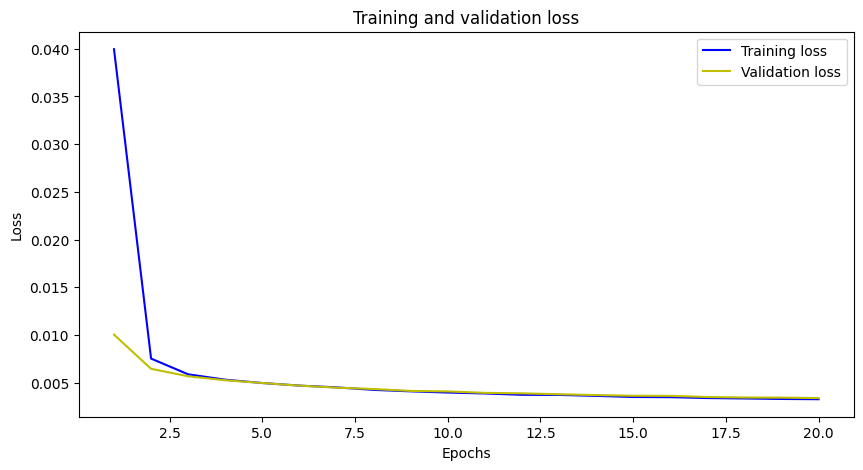

In [179]:
plot_loss(history, 20)

In [180]:
predictions = u_net.predict(down_test)

9/9 [==============================] - 26s 3s/step


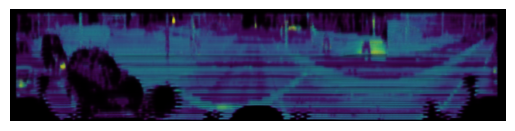

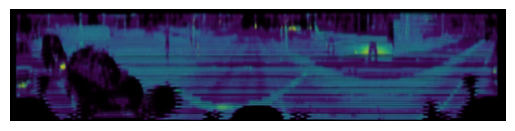

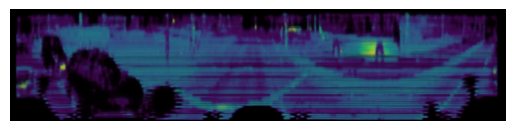

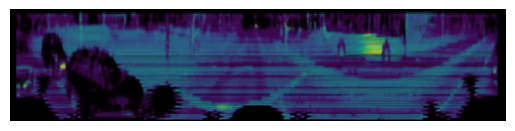

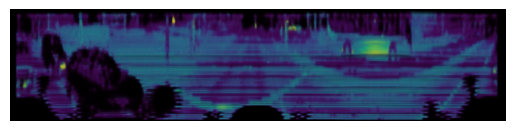

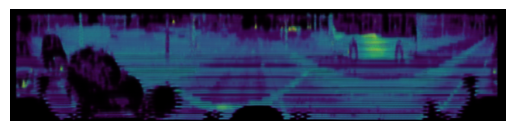

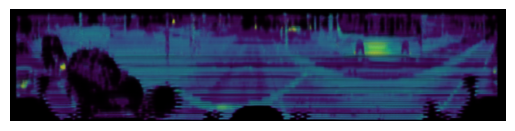

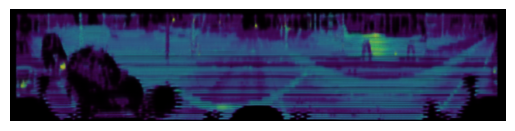

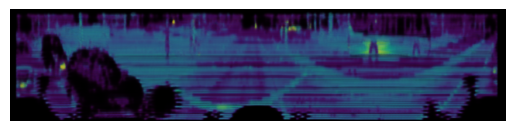

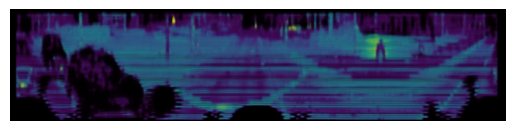

In [181]:
for i in range(10):
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

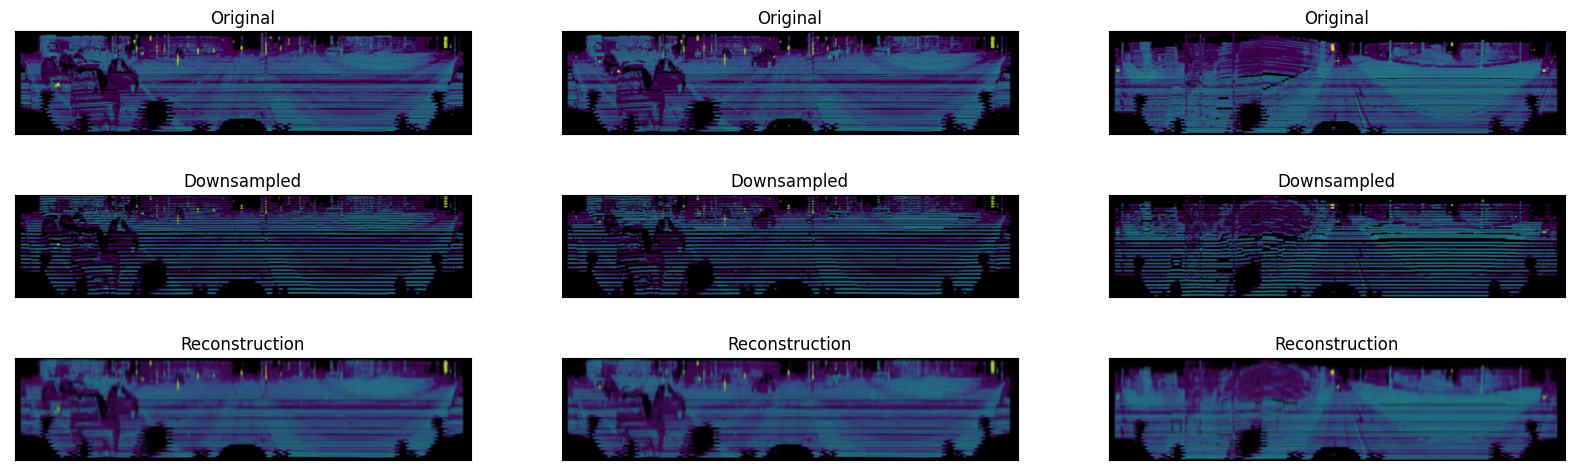

In [182]:
n = 3  
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### UNet 3

In [183]:

def unet_model(input_size=input_dim):  # Adjust input size for larger images
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    # p1 = MaxPooling2D((2, 2))(c1)
    p1 = AveragePooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    # p2 = MaxPooling2D((2, 2))(c2)
    p2 = AveragePooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    # p3 = MaxPooling2D((2, 2))(c3)
    p3 = AveragePooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    # p4 = MaxPooling2D((2, 2))(c4)
    p4 = AveragePooling2D((2, 2))(c4)

    # Bottleneck
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    d = Dropout(0.3)(c6)

    # Decoder
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d)
    u7 = concatenate([u7, c4])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c3])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8) 
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c2])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c1])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)


    # Capa de salida
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c10)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

u_net = unet_model()

In [184]:
u_net.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 144, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_85 (Conv2D)             (None, 144, 640, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 144, 640, 32  9248        ['conv2d_85[0][0]']              
                                )                                                          

In [185]:
history = u_net.fit(train_down, train_orig, epochs=20, batch_size=32, validation_data=(test_down, test_orig))

Epoch 1/20
25/25 [==============================] - 365s 14s/step - loss: 0.0330 - val_loss: 0.0104
Epoch 2/20
25/25 [==============================] - 357s 14s/step - loss: 0.0077 - val_loss: 0.0065
Epoch 3/20
25/25 [==============================] - 358s 14s/step - loss: 0.0058 - val_loss: 0.0055
Epoch 4/20
25/25 [==============================] - 360s 14s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/20
25/25 [==============================] - 358s 14s/step - loss: 0.0047 - val_loss: 0.0047
Epoch 6/20
25/25 [==============================] - 358s 14s/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/20
25/25 [==============================] - 358s 14s/step - loss: 0.0043 - val_loss: 0.0043
Epoch 8/20
25/25 [==============================] - 361s 14s/step - loss: 0.0040 - val_loss: 0.0041
Epoch 9/20
25/25 [==============================] - 359s 14s/step - loss: 0.0039 - val_loss: 0.0039
Epoch 10/20
25/25 [==============================] - 360s 14s/step - loss: 0.0037 - val_loss: 0.0038

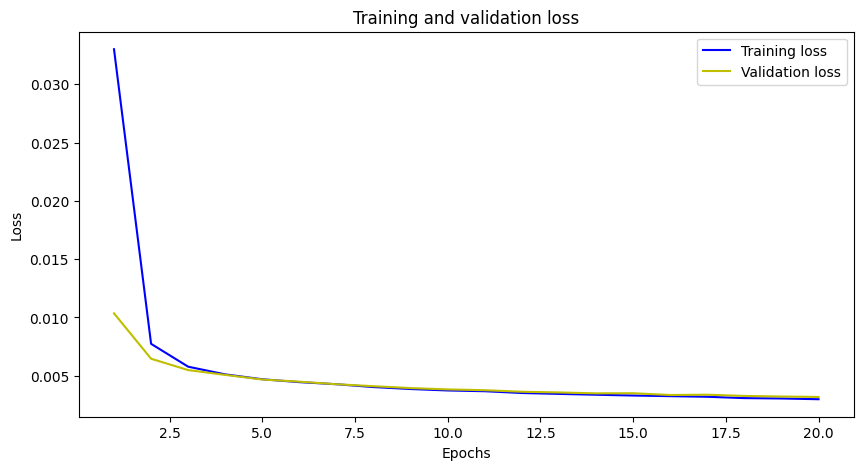

In [186]:
plot_loss(history, 20)

In [187]:
predictions = u_net.predict(down_test)

9/9 [==============================] - 30s 3s/step


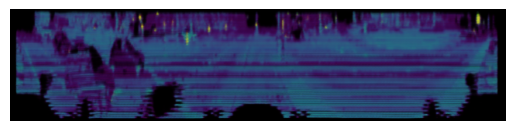

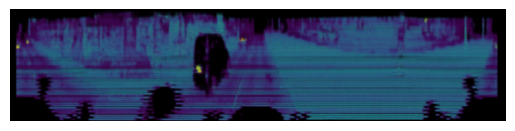

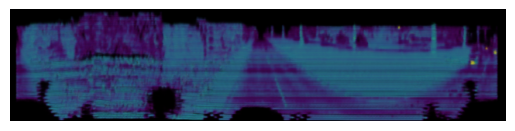

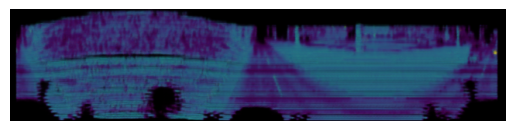

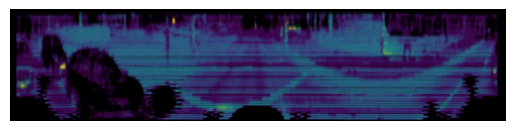

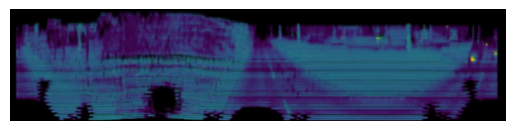

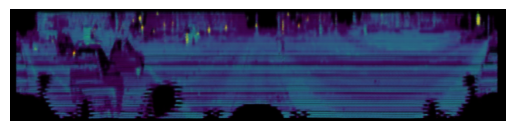

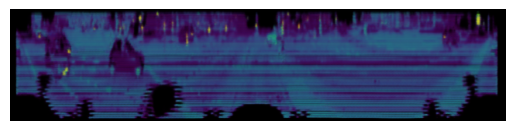

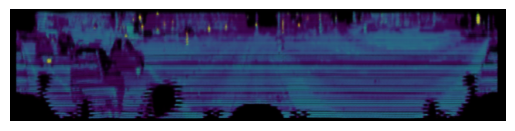

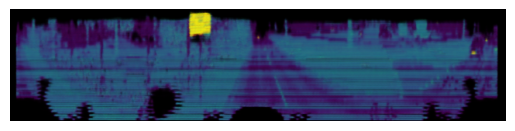

In [188]:
indices = np.random.choice(len(down_test), 10, replace=False)

for i in indices:
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.show()

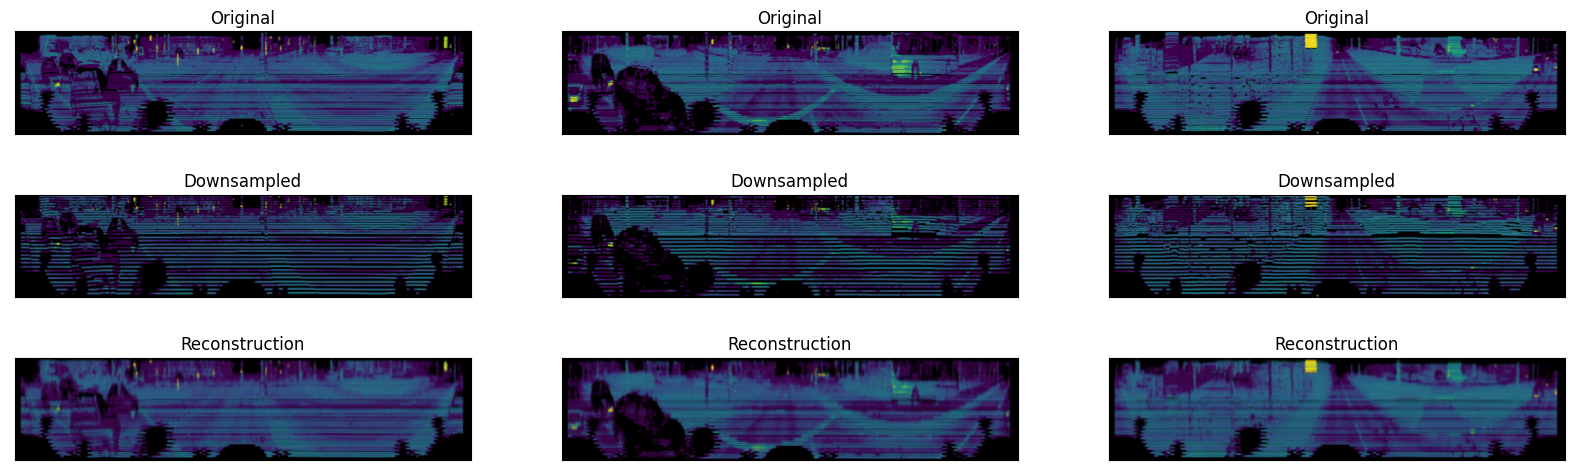

In [189]:
n = 3  
indices = np.random.choice(len(down_test), n, replace=False)

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(orig_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reducida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(down_test[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Downsampled")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[idx].reshape(144, 640, 3))
    plt.gray()
    plt.title("Reconstruction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()